# Klasifikasi Kupu-kupu

# Model HRNet

## Library

In [ ]:
import os
import torch
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import timm
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/kupu"

## Preprocessing

In [ ]:
# Transform data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print(f"Dataset Size: {len(dataset)}")

Dataset Size: 800


In [ ]:
# Membagi dataset menjadi train dan test
train_size = int(0.8 * len(dataset))  # 80% untuk training
test_size = len(dataset) - train_size  # 20% untuk testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
# DataLoader untuk train dan test
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Label mapping
label_map = dataset.class_to_idx
print(f"Label Mapping: {label_map}")

Label Mapping: {'kupu_batik_cap': 0, 'kupu_harimau_kuning_hijau': 1, 'kupu_hijau_biru': 2, 'kupu_jarak': 3, 'kupu_jojo': 4, 'kupu_pantat_merah': 5, 'kupu_raja_helena': 6, 'kupu_raja_limau': 7}


## Modelling

In [ ]:
model = timm.create_model('hrnet_w18', pretrained=True)

In [ ]:
# Jumlah Kelas
num_classes = len(label_map)
model.fc = nn.Linear(model.num_features, num_classes)

In [ ]:
# Pindahkan model ke device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=5):
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total * 100
        train_losses.append(train_loss)

        test_accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, test_accuracies

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    report = classification_report(all_labels, all_predictions, target_names=list(label_map.keys()), output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return accuracy, precision, recall, f1

In [ ]:
num_epochs = 5
train_losses, test_accuracies = train_model(
    model, train_loader, test_loader, optimizer, criterion, device, num_epochs)

Epoch 1/5, Loss: 1.3439, Train Accuracy: 83.91%, Test Accuracy: 100.00%
Epoch 2/5, Loss: 0.0221, Train Accuracy: 99.69%, Test Accuracy: 100.00%
Epoch 3/5, Loss: 0.0148, Train Accuracy: 99.84%, Test Accuracy: 100.00%
Epoch 4/5, Loss: 0.0092, Train Accuracy: 99.84%, Test Accuracy: 100.00%
Epoch 5/5, Loss: 0.0031, Train Accuracy: 100.00%, Test Accuracy: 100.00%


In [ ]:
model_save_path = "/content/hrnet_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/hrnet_model.pth


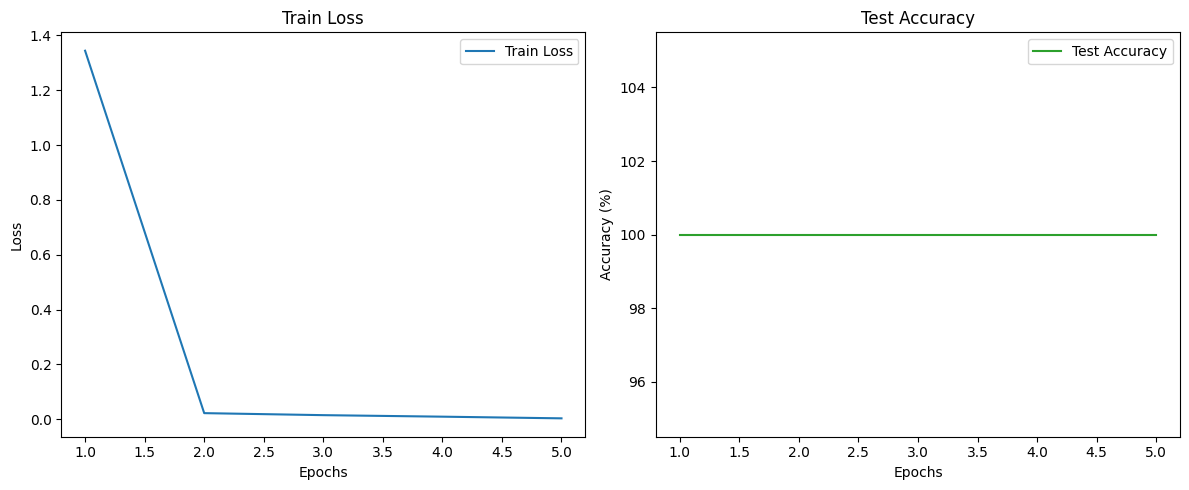

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, num_epochs + 1), train_losses, color='tab:blue', label='Train Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), test_accuracies, color='tab:green', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy')
ax2.legend()

fig.tight_layout()

plt.show()


In [ ]:
final_accuracy, final_precision, final_recall, final_f1 = evaluate_model(model, test_loader, device)

print(f"Final Test Accuracy: {final_accuracy:.2f}%")
print(f"Final Precision: {final_precision:.2f}%")
print(f"Final Recall: {final_recall:.2f}%")
print(f"Final F1-Score: {final_f1:.2f}%")

Final Test Accuracy: 100.00%
Final Precision: 1.00%
Final Recall: 1.00%
Final F1-Score: 1.00%


# Model ConvNeXt

## Library

In [ ]:
!unzip kupu.zip

Archive:  kupu.zip
   creating: kupu/
   creating: kupu/kupu_batik_cap/
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-1.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-10.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-100.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-11.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-12.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-13.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-14.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-15.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-16.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-17.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-18.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-19.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-2.JPG  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-20.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-21.jpg  
  inflating: kupu/kupu_batik_cap/Kupu Batik Cap-22.JPG  
  inflating: kupu

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from PIL import Image
import os

## Preprocessing

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_labels = []
        self.image_paths = []

        for label in os.listdir(image_dir):
            label_path = os.path.join(image_dir, label)
            if os.path.isdir(label_path):
                for filename in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, filename))
                    self.image_labels.append(label)

        # Konversi label menjadi angka
        self.label_encoder = LabelEncoder()
        self.image_labels = self.label_encoder.fit_transform(self.image_labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.image_labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
image_dir = '/content/kupu'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = CustomImageDataset(image_dir, transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Modelling

In [ ]:
model = timm.create_model('convnext_tiny', pretrained=True)
num_classes = len(set(dataset.image_labels))
model.head.fc = nn.Linear(model.num_features, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
num_epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluasi
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = (correct / total) * 100
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

Epoch [1/5], Loss: 3.3957, Accuracy: 8.12%
Epoch [2/5], Loss: 2.1519, Accuracy: 13.12%
Epoch [3/5], Loss: 2.1067, Accuracy: 9.38%
Epoch [4/5], Loss: 2.0778, Accuracy: 8.12%
Epoch [5/5], Loss: 2.1655, Accuracy: 8.12%


In [ ]:
model_save_path = "/content/convnext_model.pth"

torch.save(model.state_dict(), model_save_path)

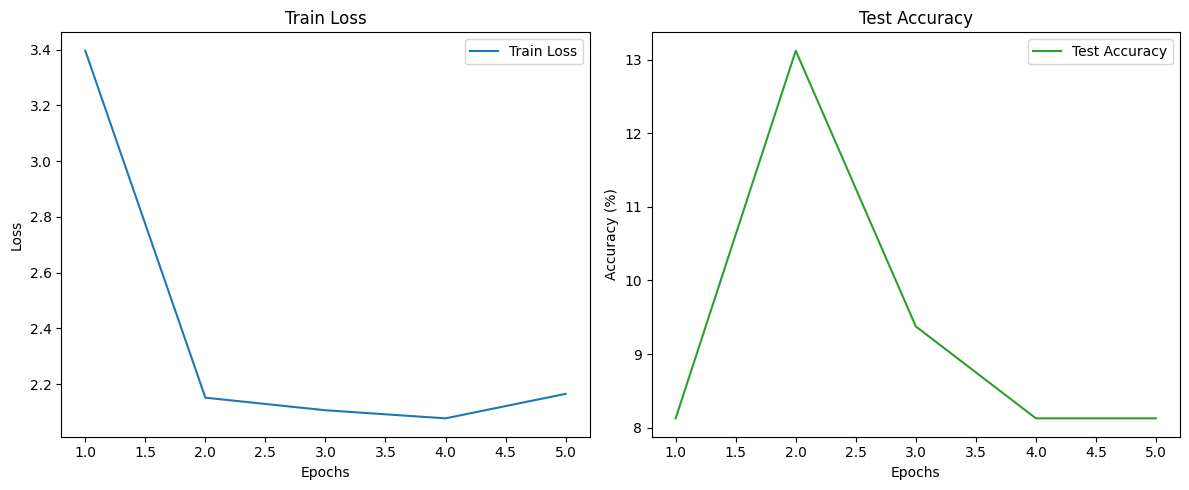

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, num_epochs + 1), train_losses, color='tab:blue', label='Train Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')
ax1.legend()

ax2.plot(range(1, num_epochs + 1), test_accuracies, color='tab:green', label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy')
ax2.legend()

fig.tight_layout()

plt.show()

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    report = classification_report(all_labels, all_predictions, target_names=list(label_map.keys()), output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return accuracy, precision, recall, f1

In [ ]:
import warnings
warnings.filterwarnings('ignore')

final_accuracy, final_precision, final_recall, final_f1 = evaluate_model(model, test_loader, device)

print(f"Final Test Accuracy: {final_accuracy:.2f}%")
print(f"Final Precision: {final_precision:.2f}%")
print(f"Final Recall: {final_recall:.2f}%")
print(f"Final F1-Score: {final_f1:.2f}%")

Final Test Accuracy: 8.12%
Final Precision: 0.01%
Final Recall: 0.12%
Final F1-Score: 0.02%


# Swin Transformer

In [5]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
from torchvision.models import swin_t, Swin_T_Weights
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [6]:
# Parameters
batch_size = 32
num_epochs = 5
learning_rate = 0.001
image_size = (224, 224)
data_dir = "/content/kupu"

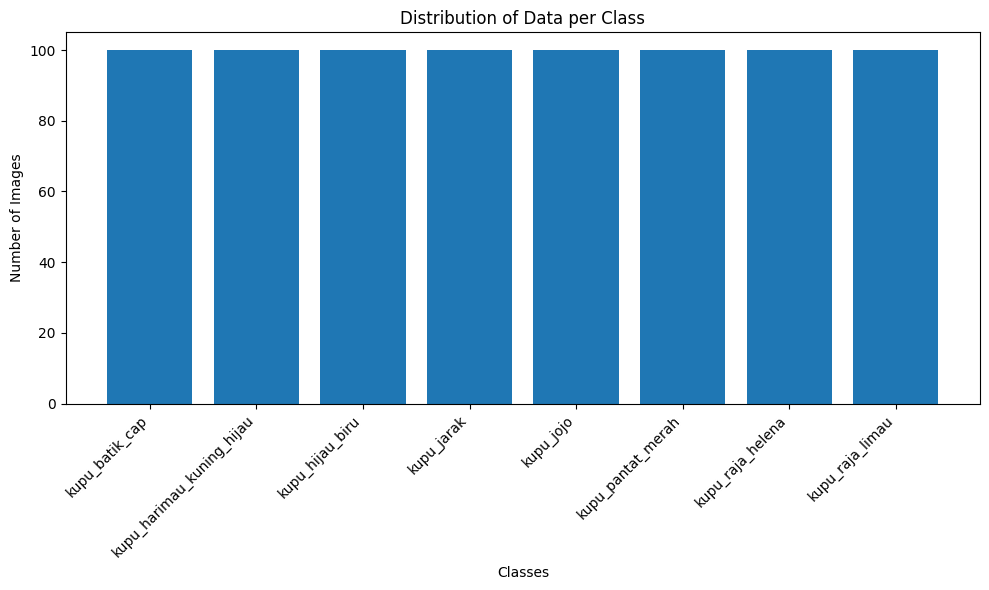

In [21]:
import matplotlib.pyplot as plt

class_counts = {}
for _, label in dataset:
    class_name = dataset.classes[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Data per Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

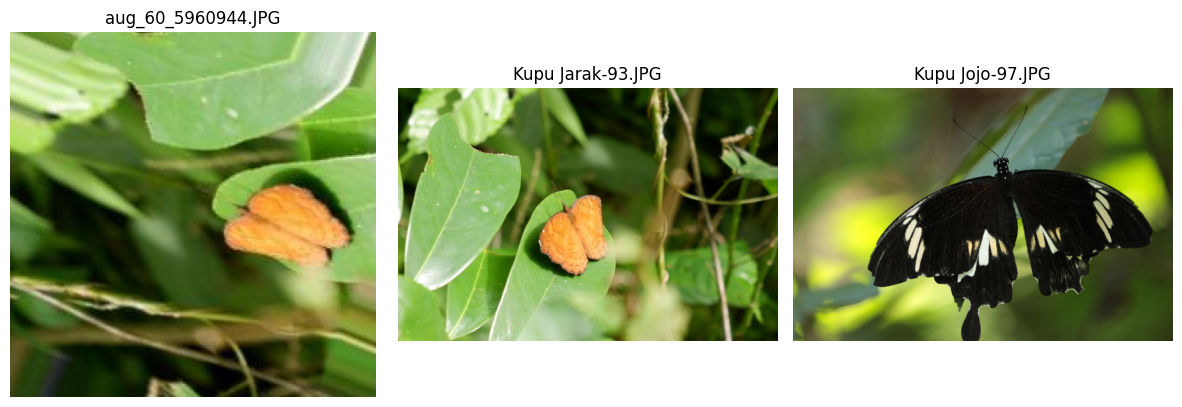

In [24]:
import matplotlib.pyplot as plt
import random
import os

image_dir = "/content/kupu"

def display_random_image(image_dir):
    all_images = []
    for subdir, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(subdir, file))

    if not all_images:
        print("No images found in the directory.")
        return

    random_image_paths = random.sample(all_images, min(3, len(all_images)))

    plt.figure(figsize=(12, 4))
    for i, image_path in enumerate(random_image_paths):
        plt.subplot(1, 3, i + 1)
        try:
          img = plt.imread(image_path)
          plt.imshow(img)
          plt.title(os.path.basename(image_path))
          plt.axis('off')
        except Exception as e:
          print(f"Error displaying image {image_path}: {e}")
    plt.tight_layout()
    plt.show()


display_random_image(image_dir)

In [7]:
# Preprocessing dan augmentasi
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)

In [8]:
# Split data (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Load pre-trained Swin Transformer
model = swin_t(weights=Swin_T_Weights.DEFAULT)
model.head = nn.Linear(model.head.in_features, num_classes)  # Adjust for 8 classes

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 151MB/s]


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [16]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1/5: 100%|██████████| 20/20 [02:14<00:00,  6.75s/it]


Epoch 1, Loss: 0.1406, Accuracy: 96.09%


Epoch 2/5: 100%|██████████| 20/20 [02:08<00:00,  6.43s/it]


Epoch 2, Loss: 0.0696, Accuracy: 98.28%


Epoch 3/5: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


Epoch 3, Loss: 0.0332, Accuracy: 99.06%


Epoch 4/5: 100%|██████████| 20/20 [02:09<00:00,  6.48s/it]


Epoch 4, Loss: 0.4230, Accuracy: 91.72%


Epoch 5/5: 100%|██████████| 20/20 [02:07<00:00,  6.37s/it]

Epoch 5, Loss: 0.5130, Accuracy: 83.44%


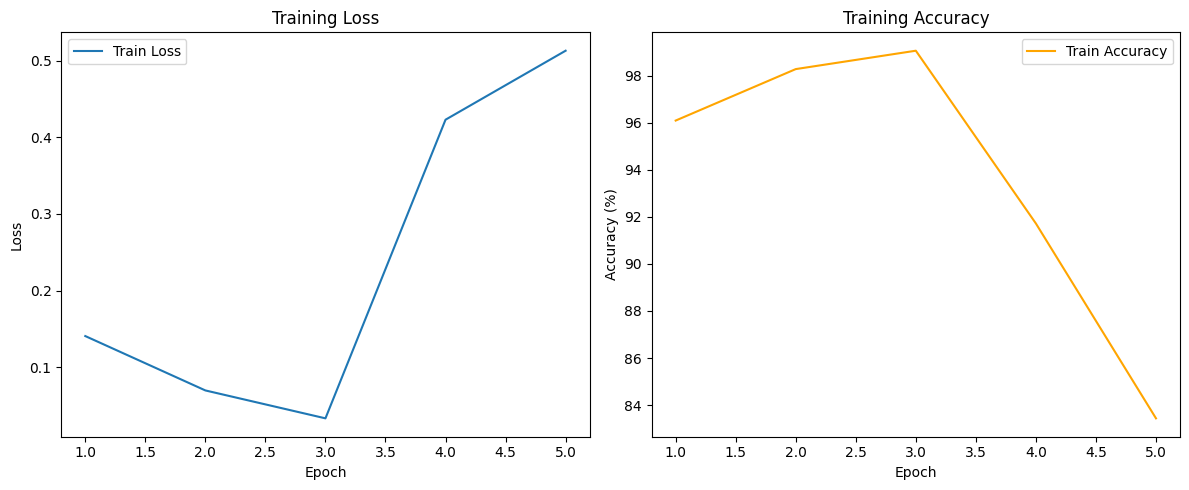

In [19]:
# Plotting Loss dan Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

final_accuracy = accuracy_score(y_true, y_pred) * 100
final_precision = precision_score(y_true, y_pred, average='weighted') * 100
final_recall = recall_score(y_true, y_pred, average='weighted') * 100
final_f1 = f1_score(y_true, y_pred, average='weighted') * 100

print(f"Final Test Accuracy: {final_accuracy:.2f}%")
print(f"Final Precision: {final_precision:.2f}%")
print(f"Final Recall: {final_recall:.2f}%")
print(f"Final F1-Score: {final_f1:.2f}%")

Final Test Accuracy: 91.88%
Final Precision: 92.91%
Final Recall: 91.88%
Final F1-Score: 91.87%
